# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

2025-05-10 17:34:18.453933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 17:34:18.591140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-10 17:34:18.591162: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-10 17:34:18.625880: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 17:34:19.791644: W tensorflow/stream_executor/platform/de

[]


2025-05-10 17:34:20.815240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-10 17:34:20.815266: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-10 17:34:20.815282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davide-C640): /proc/driver/nvidia/version does not exist


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


## **Training Data**

In [4]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [5]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

- Merge the data of the agents between the stations.

In [6]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train

merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128614, 24), (128614, 1)
Agent O3 train set shape: 	(85826, 24), (85826, 1)
Agent PM10 train set shape: 	(5283, 33), (5283, 1)
Agent PM2.5 train set shape: 	(3519, 33), (3519, 1)
Agent C6H6 train set shape: 	(40778, 24), (40778, 1)
Agent CO train set shape: 	(43036, 24), (43036, 1)


## **Models**

### **Hourly Models**

In [7]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [8]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [9]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [ ]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [11]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

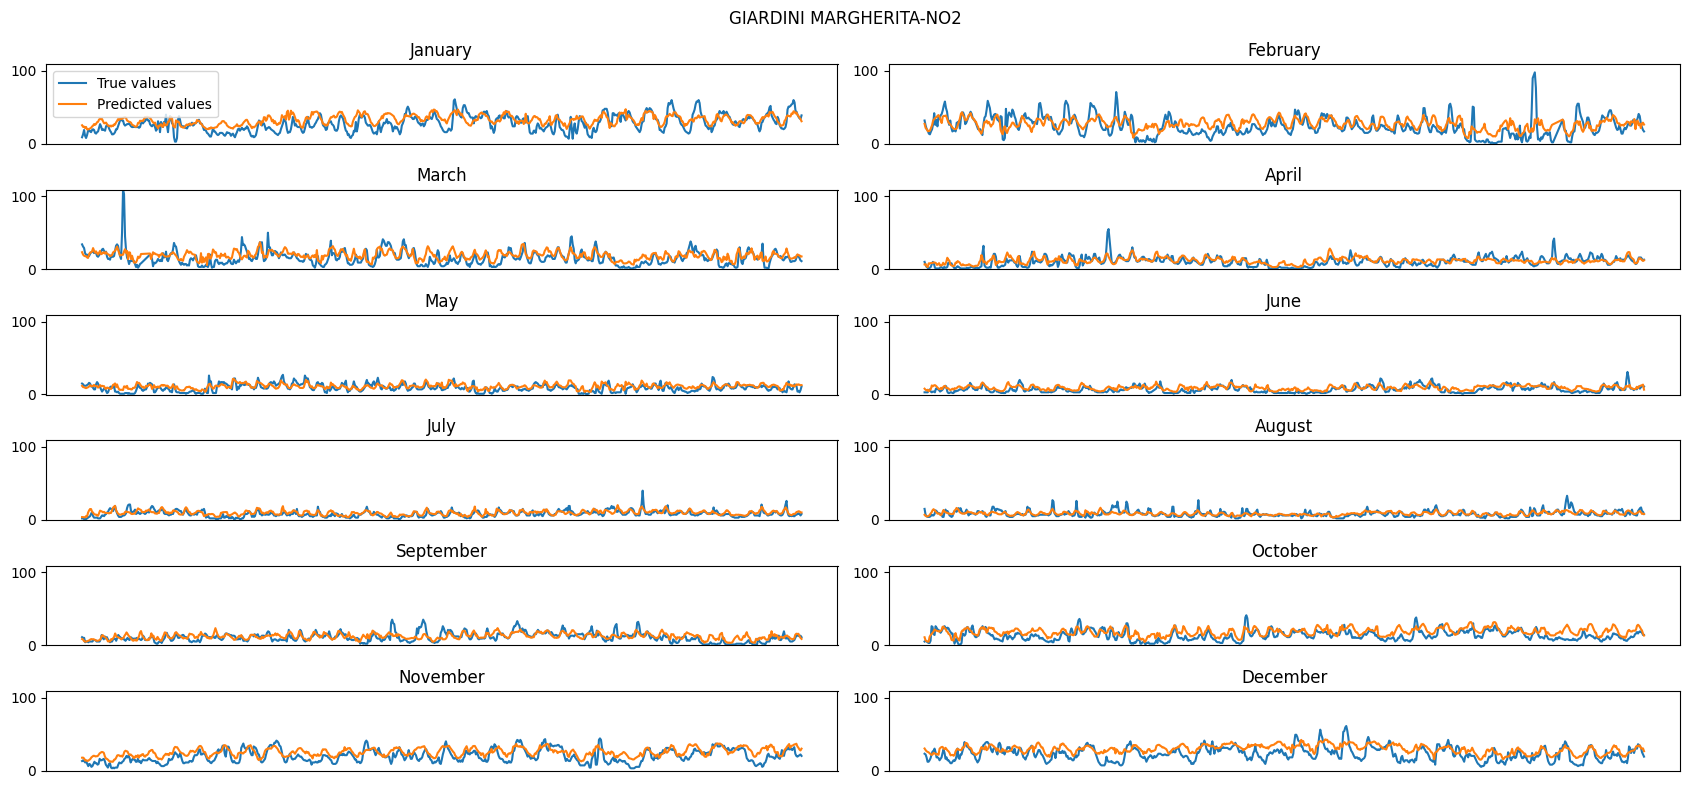

root_mean_squared_error: 0.5929249580272762
r2_score: 0.5012595358448102
mean_absolute_error: 0.43995224039251374
mean_squared_error: 0.35156000585164726


In [12]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [10]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [11]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [15]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [16]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.77954
[1]	validation_0-mae:0.75116
[2]	validation_0-mae:0.72533
[3]	validation_0-mae:0.70201
[4]	validation_0-mae:0.68127
[5]	validation_0-mae:0.66203
[6]	validation_0-mae:0.64488
[7]	validation_0-mae:0.62911
[8]	validation_0-mae:0.61531
[9]	validation_0-mae:0.60191
[10]	validation_0-mae:0.59008
[11]	validation_0-mae:0.57931
[12]	validation_0-mae:0.56978
[13]	validation_0-mae:0.56106
[14]	validation_0-mae:0.55300
[15]	validation_0-mae:0.54548
[16]	validation_0-mae:0.53837
[17]	validation_0-mae:0.53195
[18]	validation_0-mae:0.52619
[19]	validation_0-mae:0.52097
[20]	validation_0-mae:0.51657
[21]	validation_0-mae:0.51192
[22]	validation_0-mae:0.50771
[23]	validation_0-mae:0.50376
[24]	validation_0-mae:0.50037
[25]	validation_0-mae:0.49730
[26]	validation_0-mae:0.49397
[27]	validation_0-mae:0.49122
[28]	validation_0-mae:0.48858
[29]	validation_0-mae:0.48612
[30]	validation_0-mae:0.48417
[31]	validation_0-mae:0.48216
[32]	validation_0-mae:0.48030
[33]	validation_0-ma

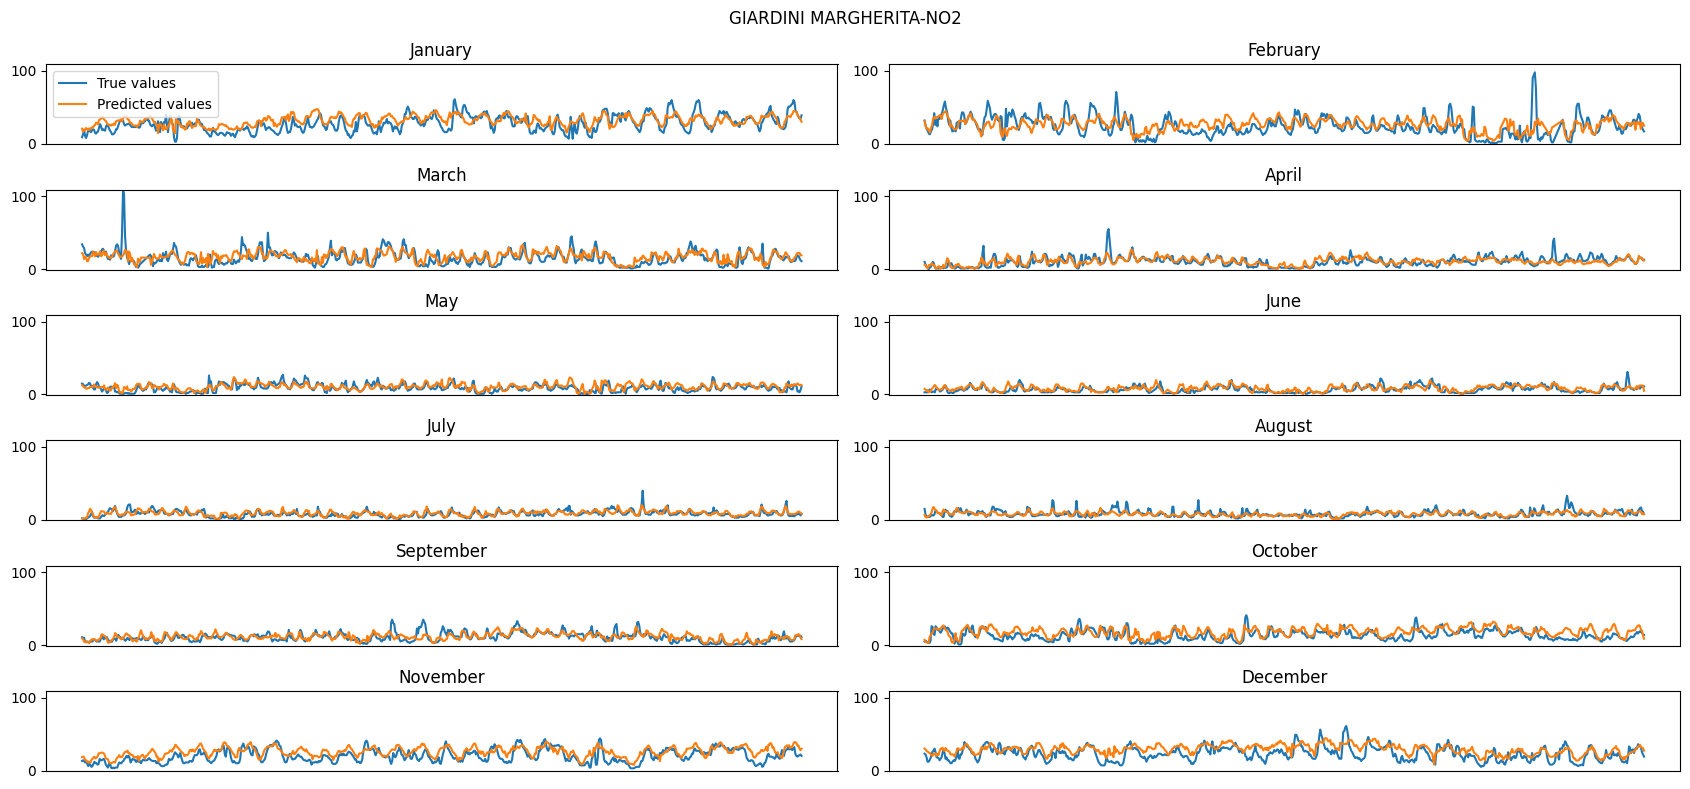

root_mean_squared_error: 0.5794168796341527
r2_score: 0.523725392240904
mean_absolute_error: 0.418073967773765
mean_squared_error: 0.3357239204049781


In [17]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [12]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [13]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':32,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [14]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [15]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [22]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM'

In [52]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']

lstm_X_train, lstm_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if lstm_X_train is None:
            lstm_X_train = X_train
            lstm_y_train = y_train
        else:
            lstm_X_train = np.concatenate((lstm_X_train, X_train), axis=0)
            lstm_y_train = np.concatenate((lstm_y_train, y_train), axis=0)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/20
1809/1809 [==============================] - 12s 5ms/step - loss: 0.4844 - val_loss: 0.4698
Epoch 2/20
1809/1809 [==============================] - 8s 4ms/step - loss: 0.4654 - val_loss: 0.4621
Epoch 3/20
1809/1809 [==============================] - 8s 4ms/step - loss: 0.4572 - val_loss: 0.4563
Epoch 4/20
1809/1809 [==============================] - 10s 5ms/step - loss: 0.4516 - val_loss: 0.4537
Epoch 5/20
1809/1809 [==============================] - 9s 5ms/step - loss: 0.4458 - val_loss: 0.4480
Epoch 6/20
1809/1809 [==============================] - 9s 5ms/step - loss: 0.4401 - val_loss: 0.4453
Epoch 7/20
1809/1809 [==============================] - 10s 5ms/step - loss: 0.4355 - val_loss: 0.4410
Epoch 8/20
1809/1809 [==============================] - 10s 6ms/step - loss: 0.4315 - val_loss: 0.4396
Epoch 9/20
1809/1809 [==============================] - 10s 6ms/step - loss: 0.4270 - val_loss: 0.4373
Epoch 10/20
1809/1809 [==============================] - 10s 6ms/step - loss:

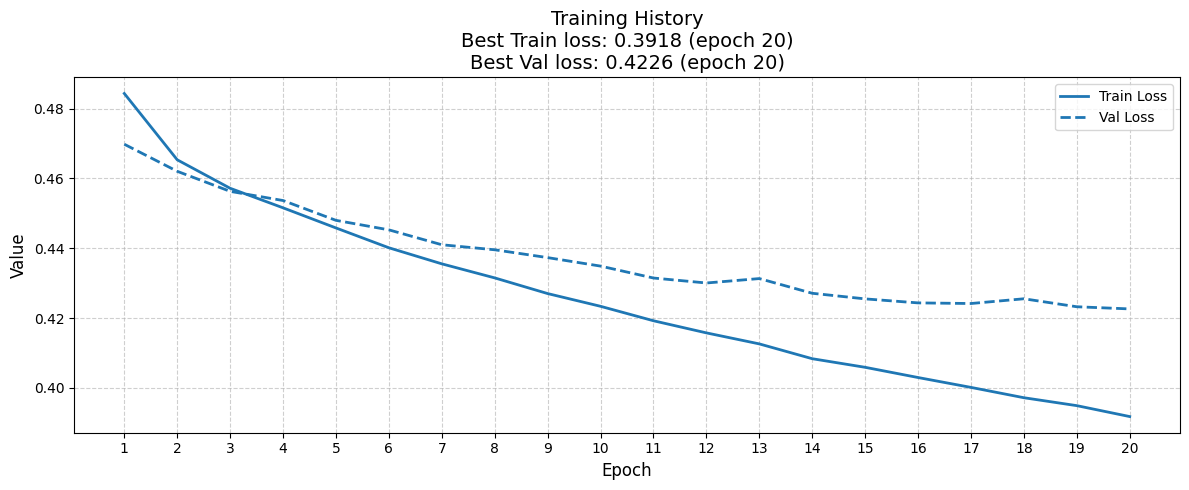

273/273 [==============================] - 2s 2ms/step


In [53]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

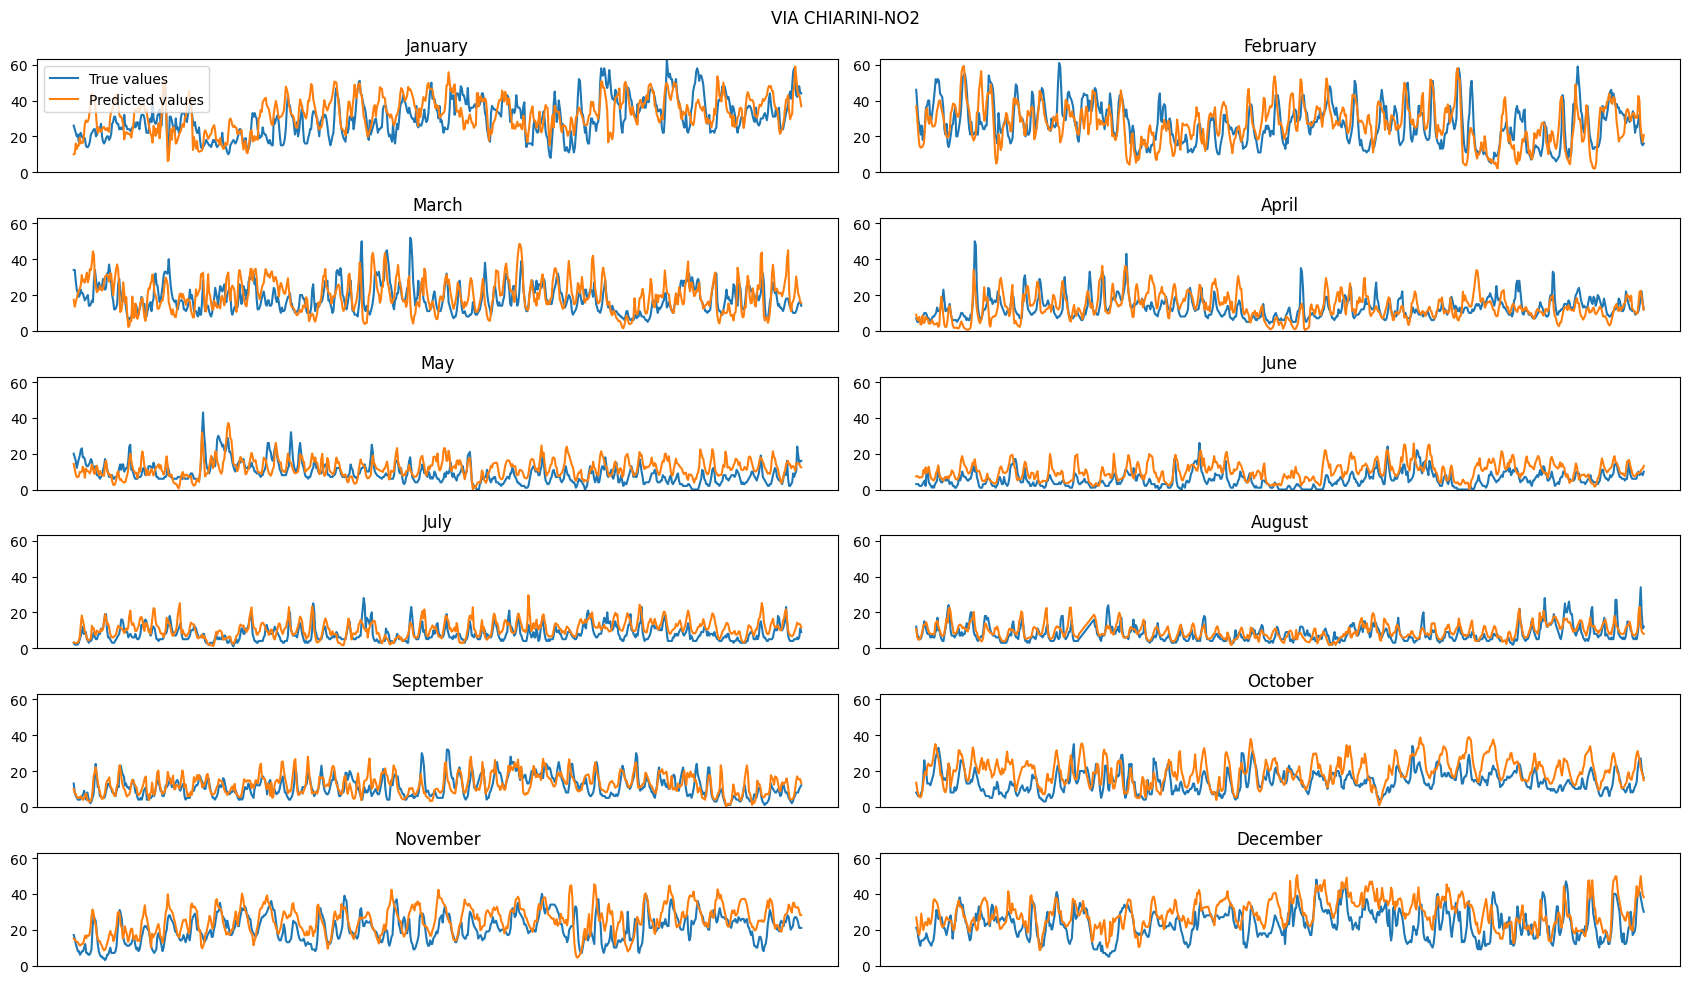

root_mean_squared_error: 0.5698918730156385
r2_score: 0.47346100708913696
mean_absolute_error: 0.4360179310132189
mean_squared_error: 0.32477674692927266


In [54]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}', figsize=(17,10))

#### Feed Forward Neural Network

##### *Models*

In [16]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [17]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

##### *Testing*

In [29]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN'

Epoch 1/10
3618/3618 [==============================] - 20s 5ms/step - loss: 0.5287 - val_loss: 0.5060
Epoch 2/10
3618/3618 [==============================] - 20s 5ms/step - loss: 0.5108 - val_loss: 0.5135
Epoch 3/10
3618/3618 [==============================] - 20s 6ms/step - loss: 0.5029 - val_loss: 0.5046
Epoch 4/10
3618/3618 [==============================] - 20s 5ms/step - loss: 0.4979 - val_loss: 0.4914
Epoch 5/10
3618/3618 [==============================] - 22s 6ms/step - loss: 0.4937 - val_loss: 0.4864
Epoch 6/10
3618/3618 [==============================] - 22s 6ms/step - loss: 0.4902 - val_loss: 0.4833
Epoch 7/10
3618/3618 [==============================] - 22s 6ms/step - loss: 0.4867 - val_loss: 0.4729
Epoch 8/10
3618/3618 [==============================] - 22s 6ms/step - loss: 0.4844 - val_loss: 0.4744
Epoch 9/10
3618/3618 [==============================] - 22s 6ms/step - loss: 0.4820 - val_loss: 0.4731
Epoch 10/10
3618/3618 [==============================] - 22s 6ms/step - l

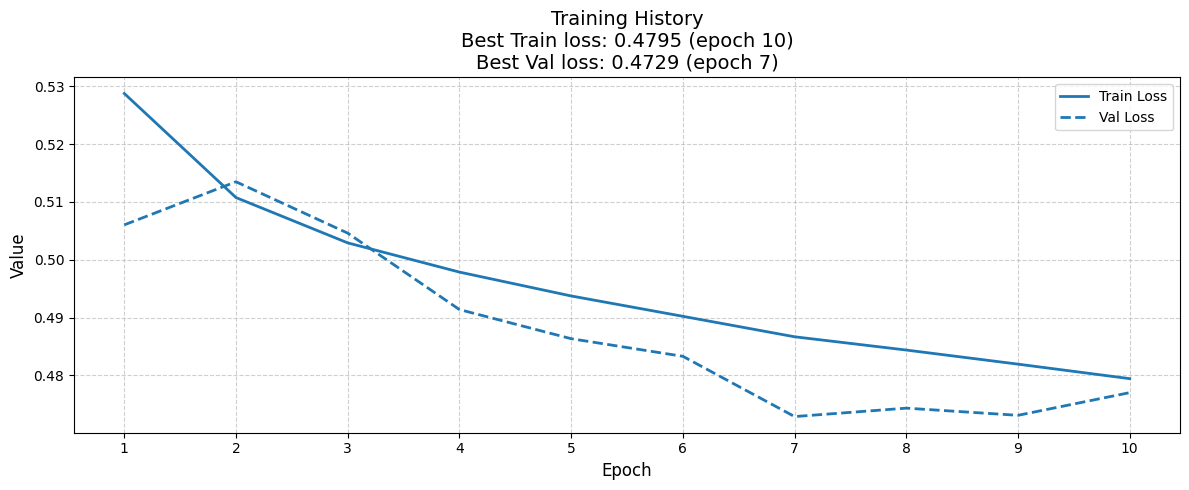

273/273 [==============================] - 1s 2ms/step


In [30]:
tf.keras.backend.clear_session()  
set_random_seed(42) 

validation_ratio = 0.1
X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_history = ffnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    **hour_models[selected_ffnn][2]
)
plot_history(ffnn_history)
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

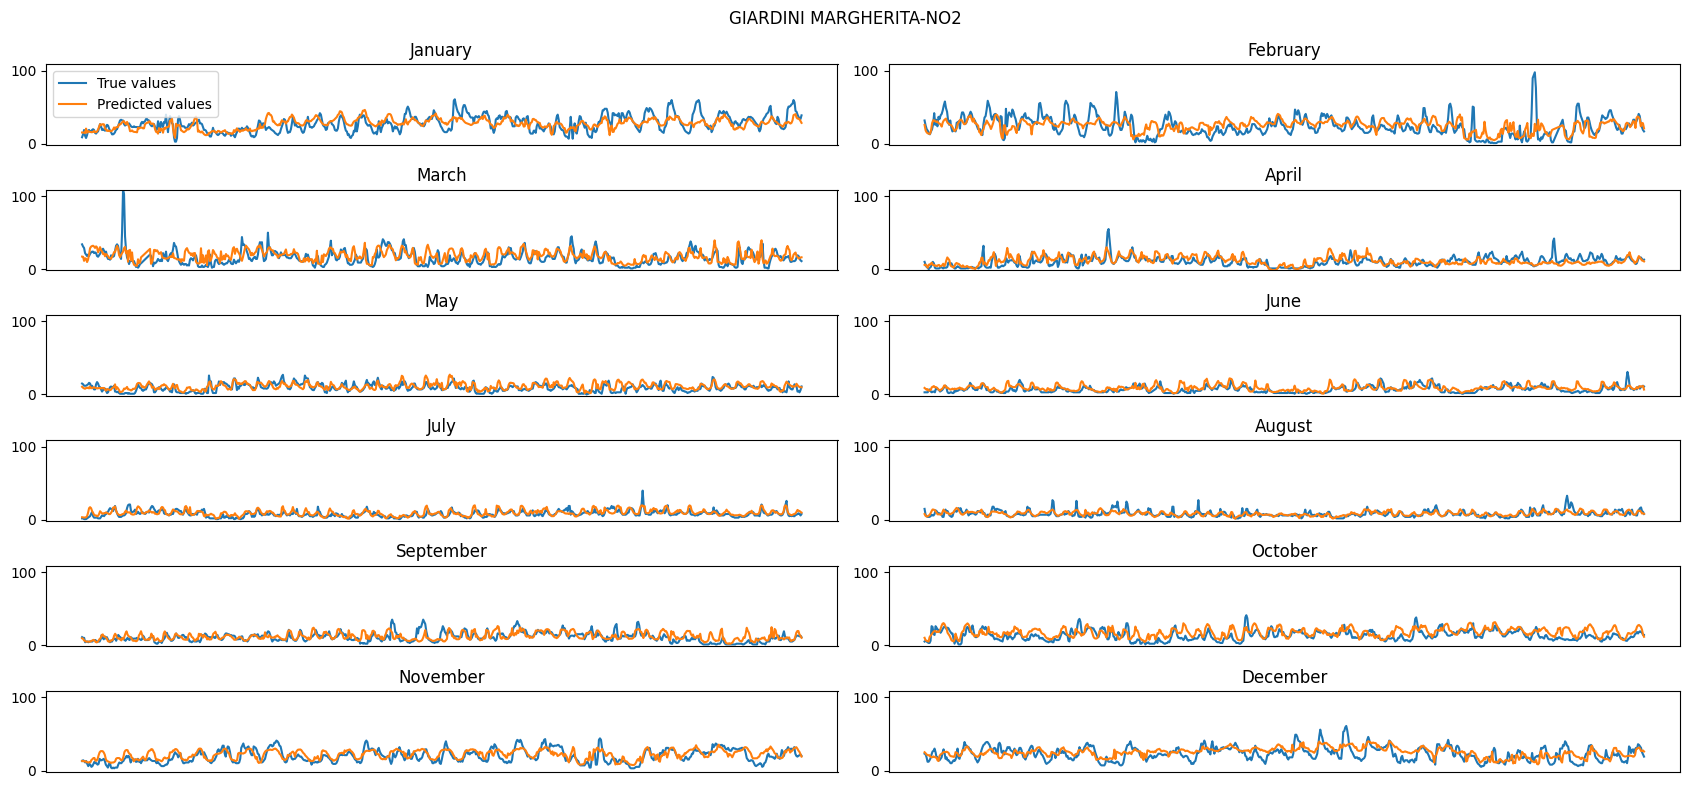

root_mean_squared_error: 0.5787803131509636
r2_score: 0.5247713193470167
mean_absolute_error: 0.41741085948075296
mean_squared_error: 0.3349866508911274


In [31]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [18]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [19]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [20]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [60]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [61]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if conv_X_train is None:
            conv_X_train = X_train
            conv_y_train = y_train
        else:
            conv_X_train = np.concatenate((conv_X_train, X_train), axis=0)
            conv_y_train = np.concatenate((conv_y_train, y_train), axis=0)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4932 - val_loss: 0.4748
Epoch 2/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4724 - val_loss: 0.4723
Epoch 3/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4639 - val_loss: 0.4611
Epoch 4/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4560 - val_loss: 0.4539
Epoch 5/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4523 - val_loss: 0.4539
Epoch 6/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4486 - val_loss: 0.4497
Epoch 7/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4453 - val_loss: 0.4459
Epoch 8/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4414 - val_loss: 0.4437
Epoch 9/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4387 - val_loss: 0.4429
Epoch 10/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.436

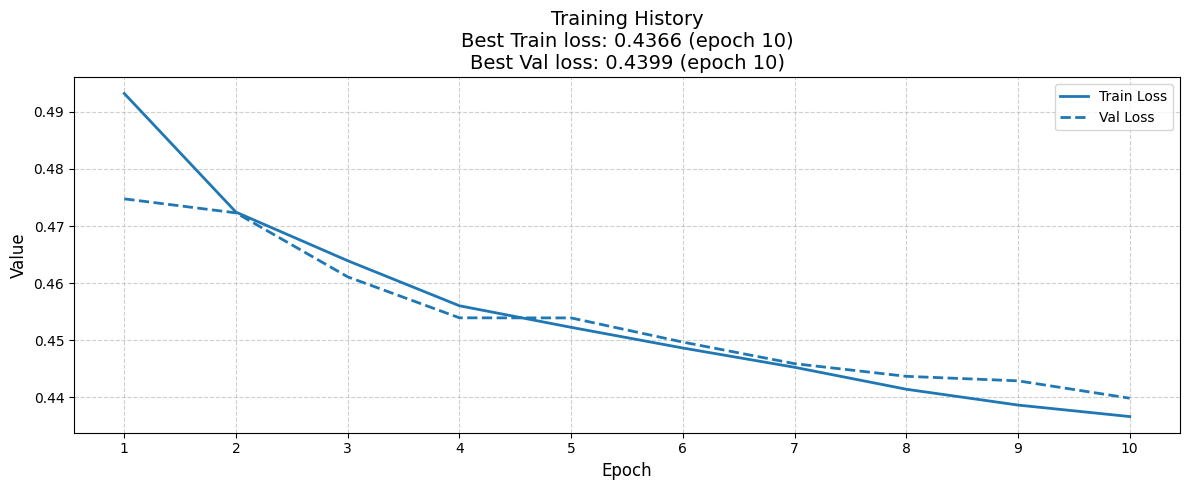

273/273 [==============================] - 0s 879us/step


In [62]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_history = conv_model.fit(
    conv_X_train, 
    conv_y_train,
    validation_data=(conv_X_val, conv_y_val),
    **hour_models[selected_conv][2])
plot_history(conv_history)
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

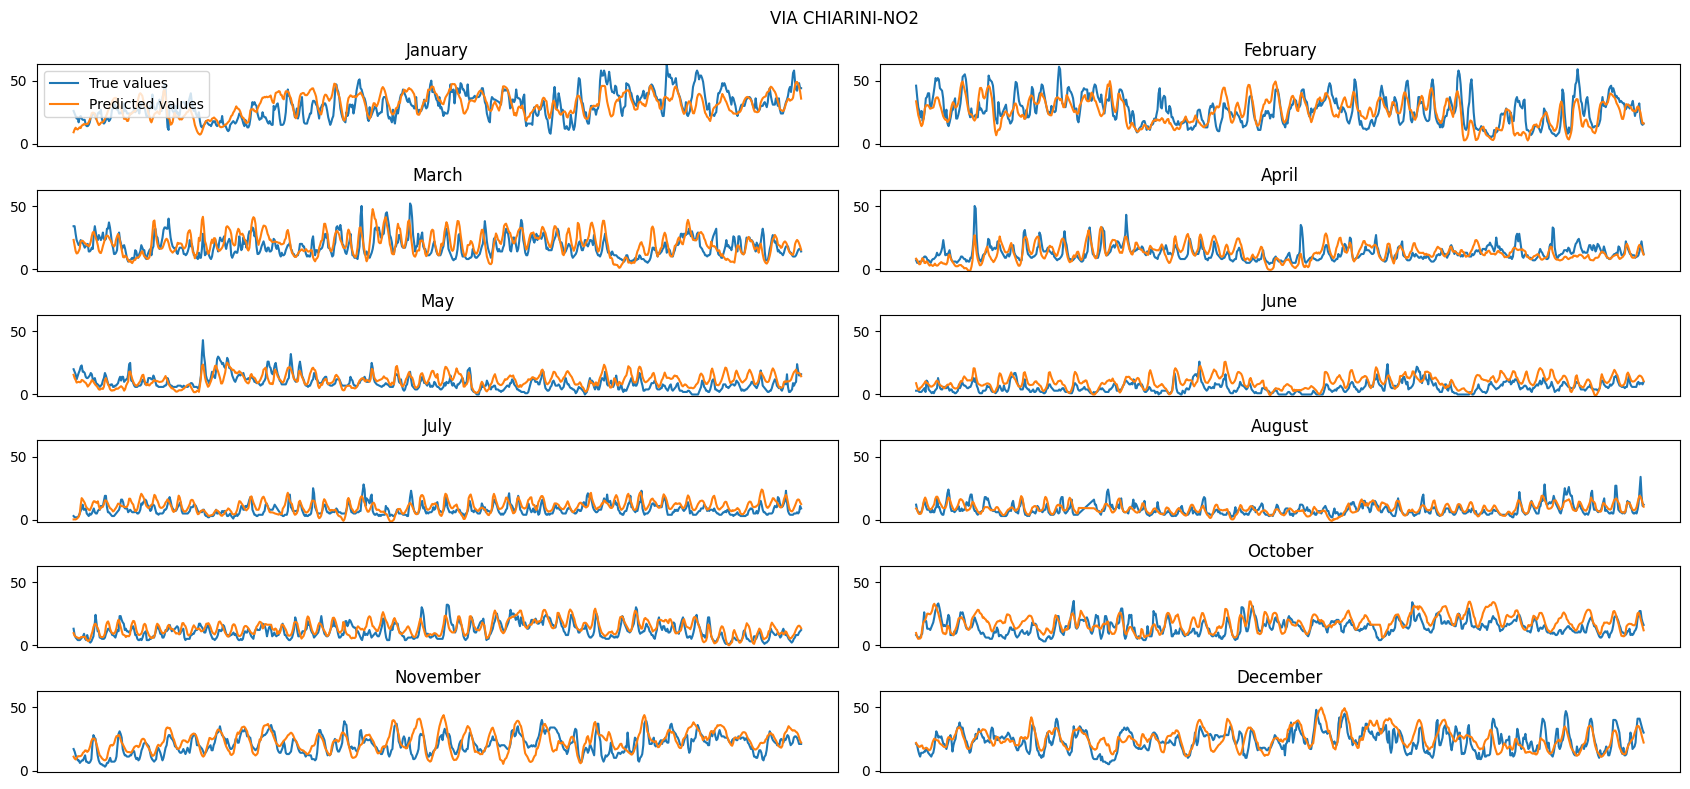

root_mean_squared_error: 0.5096264493775154
r2_score: 0.5789346248632529
mean_absolute_error: 0.3929892016622436
mean_squared_error: 0.2597191179051333


In [63]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [21]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [22]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [23]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [35]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [36]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

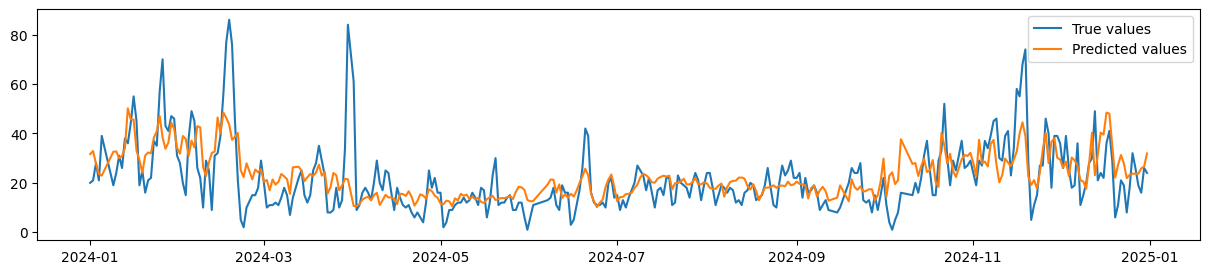

root_mean_squared_error: 0.7236807594977694
r2_score: 0.4197930582142969
mean_absolute_error: 0.5137615558222252
mean_squared_error: 0.5237138416672684


In [37]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [24]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [25]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [40]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [41]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.75187
[1]	validation_0-mae:0.73052
[2]	validation_0-mae:0.71083
[3]	validation_0-mae:0.69336
[4]	validation_0-mae:0.67836
[5]	validation_0-mae:0.66253
[6]	validation_0-mae:0.64713
[7]	validation_0-mae:0.63332
[8]	validation_0-mae:0.61982
[9]	validation_0-mae:0.60756
[10]	validation_0-mae:0.59755
[11]	validation_0-mae:0.58803
[12]	validation_0-mae:0.57879
[13]	validation_0-mae:0.57101
[14]	validation_0-mae:0.56190
[15]	validation_0-mae:0.55452
[16]	validation_0-mae:0.54502
[17]	validation_0-mae:0.53915
[18]	validation_0-mae:0.53361
[19]	validation_0-mae:0.52671
[20]	validation_0-mae:0.52159
[21]	validation_0-mae:0.51782
[22]	validation_0-mae:0.51225
[23]	validation_0-mae:0.50579
[24]	validation_0-mae:0.49985
[25]	validation_0-mae:0.49677
[26]	validation_0-mae:0.49417
[27]	validation_0-mae:0.49242
[28]	validation_0-mae:0.48909
[29]	validation_0-mae:0.48555
[30]	validation_0-mae:0.48312
[31]	validation_0-mae:0.47873
[32]	validation_0-mae:0.47655
[33]	validation_0-ma

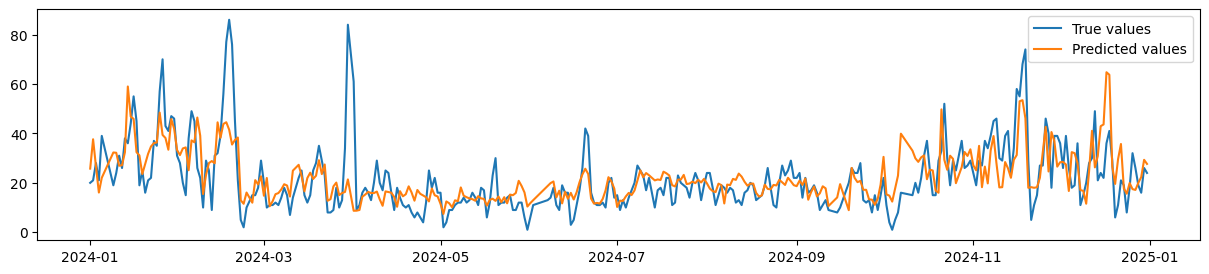

root_mean_squared_error: 0.7254542405201075
r2_score: 0.41694581701327116
mean_absolute_error: 0.5043965733302436
mean_squared_error: 0.5262838550886061


In [42]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [26]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [27]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [45]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

Epoch 1/10
149/149 [==============================] - 1s 7ms/step - loss: 0.5699 - val_loss: 0.5491
Epoch 2/10
149/149 [==============================] - 1s 6ms/step - loss: 0.5042 - val_loss: 0.5304
Epoch 3/10
149/149 [==============================] - 1s 6ms/step - loss: 0.4854 - val_loss: 0.5034
Epoch 4/10
149/149 [==============================] - 1s 6ms/step - loss: 0.4679 - val_loss: 0.4894
Epoch 5/10
149/149 [==============================] - 1s 6ms/step - loss: 0.4541 - val_loss: 0.5155
Epoch 6/10
149/149 [==============================] - 1s 6ms/step - loss: 0.4494 - val_loss: 0.4817
Epoch 7/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4382 - val_loss: 0.4730
Epoch 8/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4242 - val_loss: 0.4716
Epoch 9/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4139 - val_loss: 0.4614
Epoch 10/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4082 - val_loss: 0.4613

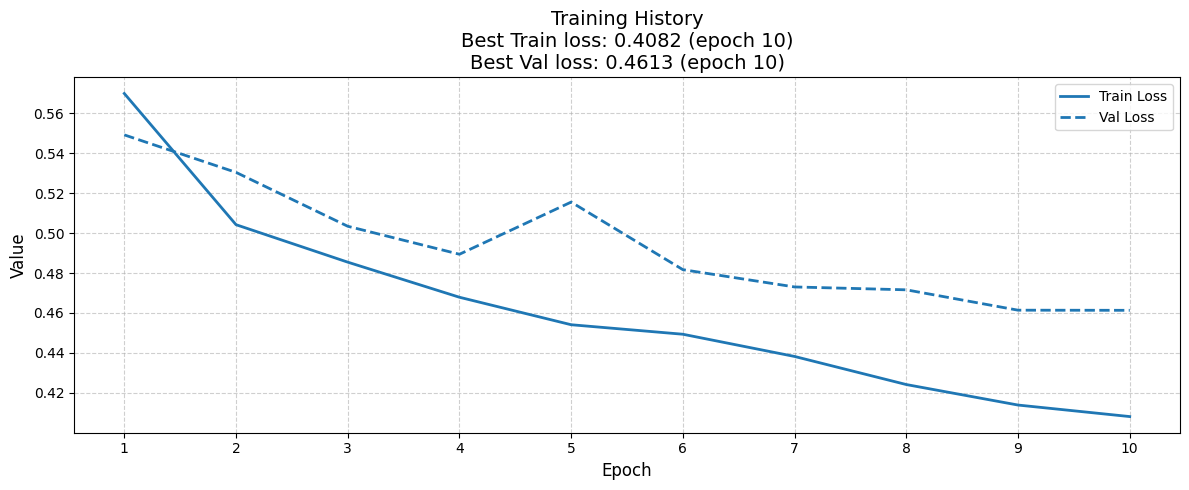

11/11 [==============================] - 0s 2ms/step


In [46]:
tf.keras.backend.clear_session()  
set_random_seed(42) 

validation_ratio = 0.1
X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_history = ffnn_daily_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    **hour_models[selected_daily_ffnn][2]
)
plot_history(ffnn_daily_history)
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

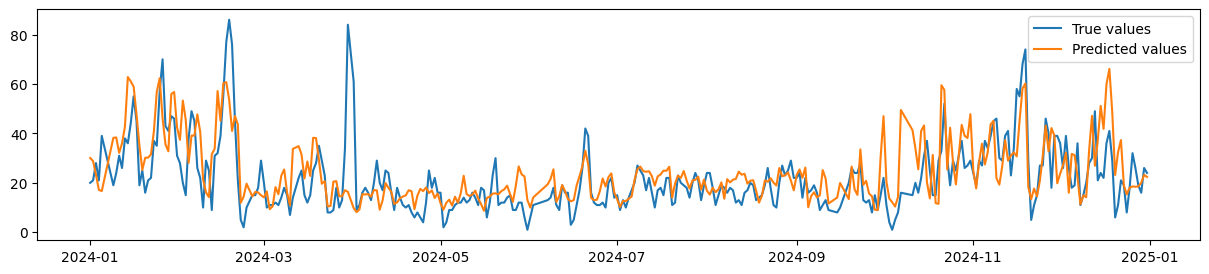

root_mean_squared_error: 0.7919608772759881
r2_score: 0.3051415803551403
mean_absolute_error: 0.5625736837643773
mean_squared_error: 0.6272020311357527


In [47]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

## **Agents Evaluations**

### Hourly Models

In [28]:
hour_results = train_models_1_per_agent(
    hour_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6', 'CO']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN 2', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent NO2
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model


2025-05-10 17:40:09.018300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent O3
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent C6H6
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent CO
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv

Since that we evaluated per-station, we need to compute the overall metric of each model for each station. To do so, we simply apply the inverse formula of the metric and then normalize across all the dataset.

*We could also put together the predictions and compute the metric, or directly evaluate per agent*.

In [29]:
hour_extracted_data = extract_model_scores(hour_results, test_sets)
hour_extracted_data_df = extracted_scores_to_dataframe(hour_extracted_data)

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
37,C6H6,Conv1D 2,0.569915,0.356020,0.324804
36,C6H6,Conv1D,0.571954,0.363444,0.327131
30,C6H6,LSTM,0.590577,0.367237,0.348781
26,C6H6,Random Forest Regressor,0.594239,0.376293,0.353120
27,C6H6,Random Forest Regressor 2,0.594878,0.376681,0.353880
28,C6H6,XGB Regressor,0.595727,0.364883,0.354891
38,C6H6,Conv1D 3,0.604969,0.367939,0.365988
31,C6H6,LSTM-masked,0.610349,0.384424,0.372525
35,C6H6,Feed Forward NN 2,0.613091,0.378888,0.375881
33,C6H6,LSTM 2-masked,0.621172,0.387141,0.385855


And we can display the best model for each station-agent

In [31]:
best_hourly = hour_extracted_data_df.loc[hour_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()]
display(best_hourly)

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
37,C6H6,Conv1D 2,0.569915,0.356020,0.324804
41,CO,XGB Regressor,0.666039,0.511999,0.443608
2,NO2,XGB Regressor,0.684722,0.540500,0.508612
15,O3,XGB Regressor,0.375479,0.281251,0.140985


Contrarely to the station-agent models, XGB models perform better accross stations. They are therefore more suitable to develop robust models that could work well when presented with new stations or agents.

#### **Comparison**

In [ ]:
hourly_comparison_results = []
comparison_agents = best_hourly['Agent']
comparison_models = best_hourly['Model']
for station in hour_results:
    for agent, model in zip(comparison_agents, comparison_models):
        if agent in hour_results[station]:
            comparison_metrics = hour_results[station][agent][model]['metric_scores']
            hourly_comparison_results.append({
                "Station": station,
                "Agent": agent,
                "Model": model,
                **comparison_metrics
            })

hourly_comparison_df = pd.DataFrame(hourly_comparison_results)
display(hourly_comparison_df)

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,NO2,XGB Regressor,0.582046,0.519394,0.419106,0.338777
1,GIARDINI MARGHERITA,O3,XGB Regressor,0.375111,0.841960,0.280218,0.140708
2,PORTA SAN FELICE,C6H6,Conv1D 2,0.569915,0.647399,0.356020,0.324804
3,PORTA SAN FELICE,CO,XGB Regressor,0.666039,0.575752,0.511999,0.443608
4,PORTA SAN FELICE,NO2,XGB Regressor,0.965672,-0.726103,0.814173,0.932523
5,VIA CHIARINI,NO2,XGB Regressor,0.510368,0.577709,0.392077,0.260475
6,VIA CHIARINI,O3,XGB Regressor,0.375849,0.837303,0.282288,0.141263


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Station</th>
      <th>Agent</th>
      <th>Model</th>
      <th>root_mean_squared_error</th>
      <th>r2_score</th>
      <th>mean_absolute_error</th>
      <th>mean_squared_error</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>26</th>
      <td>GIARDINI MARGHERITA</td>
      <td>NO2</td>
      <td>Conv1D 2</td>
      <td>0.525926</td>
      <td>0.607604</td>
      <td>0.358271</td>
      <td>0.276598</td>
    </tr>
    <tr>
      <th>13</th>
      <td>GIARDINI MARGHERITA</td>
      <td>O3</td>
      <td>Conv1D 3</td>
      <td>0.355730</td>
      <td>0.857860</td>
      <td>0.267032</td>
      <td>0.126544</td>
    </tr>
    <tr>
      <th>40</th>
      <td>PORTA SAN FELICE</td>
      <td>C6H6</td>
      <td>Conv1D 2</td>
      <td>0.559259</td>
      <td>0.660462</td>
      <td>0.350356</td>
      <td>0.312771</td>
    </tr>
    <tr>
      <th>44</th>
      <td>PORTA SAN FELICE</td>
      <td>CO</td>
      <td>XGB Regressor</td>
      <td>0.664817</td>
      <td>0.577301</td>
      <td>0.511027</td>
      <td>0.441982</td>
    </tr>
    <tr>
      <th>65</th>
      <td>PORTA SAN FELICE</td>
      <td>NO2</td>
      <td>Feed Forward NN 2</td>
      <td>0.881743</td>
      <td>-0.439108</td>
      <td>0.749211</td>
      <td>0.777470</td>
    </tr>
    <tr>
      <th>86</th>
      <td>VIA CHIARINI</td>
      <td>NO2</td>
      <td>XGB Regressor</td>
      <td>0.514019</td>
      <td>0.571648</td>
      <td>0.389214</td>
      <td>0.264215</td>
    </tr>
    <tr>
      <th>81</th>
      <td>VIA CHIARINI</td>
      <td>O3</td>
      <td>Conv1D</td>
      <td>0.332717</td>
      <td>0.872502</td>
      <td>0.250762</td>
      <td>0.110701</td>
    </tr>
  </tbody>
</table>
</div>

Loss values are slightly worse with these new models, compared to the station-agent models. Anyways, we are gaining an advantage with the fact that we are only developing one model per agent.

### Daily Models

In [33]:
daily_results = train_models_1_per_agent(
    daily_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
Agent PM2.5
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model


In [34]:
daily_extracted_data = extract_model_scores(daily_results, test_sets)
daily_extracted_data_df = extracted_scores_to_dataframe(daily_extracted_data)

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
0,PM10,Random Forest Regressor,0.750388,0.536442,0.565660
1,PM10,Random Forest Regressor 2,0.759755,0.547435,0.580058
5,PM10,Feed Forward NN BatchNorm,0.770382,0.536255,0.595115
2,PM10,XGB Regressor,0.778311,0.561480,0.609746
4,PM10,Feed Forward NN,0.781980,0.549307,0.614241
3,PM10,XGB Regressor 2,0.791981,0.574106,0.631431
10,PM2.5,Feed Forward NN,0.701495,0.475142,0.494918
7,PM2.5,Random Forest Regressor 2,0.702292,0.491699,0.494595
11,PM2.5,Feed Forward NN BatchNorm,0.705128,0.478542,0.500713
6,PM2.5,Random Forest Regressor,0.707975,0.495023,0.502503


In [48]:
best_daily = daily_extracted_data_df.loc[daily_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()]
best_daily

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
0,PM10,Random Forest Regressor,0.750388,0.536442,0.565660
10,PM2.5,Feed Forward NN,0.701495,0.475142,0.494918


#### **Comparison**

In [49]:
daily_comparison_results = []
comparison_agents = best_daily['Agent']
comparison_models = best_daily['Model']
comparison_models = ['Random Forest Regressor']+['Feed Forward NN']
for station in daily_results:
    for agent, model in zip(comparison_agents, comparison_models):
        if agent in daily_results[station]:
            comparison_metrics = daily_results[station][agent][model]['metric_scores']
            daily_comparison_results.append({
                "Station": station,
                "Agent": agent,
                "Model": model,
                **comparison_metrics
            })

daily_comparison_df = pd.DataFrame(daily_comparison_results)
display(daily_comparison_df)

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.723681,0.419793,0.513762,0.523714
1,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.755149,0.446295,0.495028,0.570250
2,PORTA SAN FELICE,PM10,Random Forest Regressor,0.707337,0.504747,0.483271,0.500326
3,PORTA SAN FELICE,PM2.5,Feed Forward NN,0.648882,0.591297,0.455640,0.421047
4,VIA CHIARINI,PM10,Random Forest Regressor,0.822801,0.343498,0.615329,0.677001


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Station</th>
      <th>Agent</th>
      <th>Model</th>
      <th>root_mean_squared_error</th>
      <th>r2_score</th>
      <th>mean_absolute_error</th>
      <th>mean_squared_error</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>GIARDINI MARGHERITA</td>
      <td>PM10</td>
      <td>Feed Forward NN BatchNorm</td>
      <td>0.714385</td>
      <td>0.434603</td>
      <td>0.502577</td>
      <td>0.510346</td>
    </tr>
    <tr>
      <th>10</th>
      <td>GIARDINI MARGHERITA</td>
      <td>PM2.5</td>
      <td>Feed Forward NN</td>
      <td>0.704822</td>
      <td>0.506765</td>
      <td>0.491546</td>
      <td>0.496775</td>
    </tr>
    <tr>
      <th>16</th>
      <td>PORTA SAN FELICE</td>
      <td>PM10</td>
      <td>Feed Forward NN</td>
      <td>0.702841</td>
      <td>0.511023</td>
      <td>0.464813</td>
      <td>0.493985</td>
    </tr>
    <tr>
      <th>22</th>
      <td>PORTA SAN FELICE</td>
      <td>PM2.5</td>
      <td>Feed Forward NN</td>
      <td>0.642601</td>
      <td>0.599170</td>
      <td>0.450156</td>
      <td>0.412936</td>
    </tr>
    <tr>
      <th>24</th>
      <td>VIA CHIARINI</td>
      <td>PM10</td>
      <td>Random Forest Regressor</td>
      <td>0.845451</td>
      <td>0.306857</td>
      <td>0.646139</td>
      <td>0.714787</td>
    </tr>
  </tbody>
</table>
</div>

The best models are the same as the station-agent models.
The metric scores are really similar, maybe the fact that the two pollutants are really highly correlated doesn't introduce new training data.

To further inspect their performance, we compare the AQI values.

In any case, we were able to achieve similar results only using one model for each agent.